In [2]:
import numpy as np
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from matplotlib import pyplot as plt
import time as tm
import random

# Dataset 1 - set of two oblique ellipsoids

muPos = np.array( [-3,0] )
muNeg = np.array( [3,3] )
cov = np.array( [[16, -14] , [-14, 16]] )

# Set n to be a large number to visualize the speed benefits of SGD/MB over GD
d = 2 
n = 6000

XPos = gsd.genEllipticalData( d, n, muPos, cov )
XNeg = gsd.genEllipticalData( d, n, muNeg, cov )
yPos = np.ones( (n,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

# Dataset 2 - set of two circles with a couple of outliers
# Comment this section out in order to try dataset 1

muPos1 = np.array( [-5,5] )
muPos2 = np.array( [1,-5] )
muNeg = np.array( [-5,-5] )
r = 3

tmp1 = gsd.genSphericalData( d, n, muPos1, r)
tmp2 = gsd.genSphericalData( d, n//30, muPos2, r//2 )
XPos = np.vstack( (tmp1, tmp2) )
XNeg = gsd.genSphericalData( d, n, muNeg, r )
yPos = np.ones( (n + n//30,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

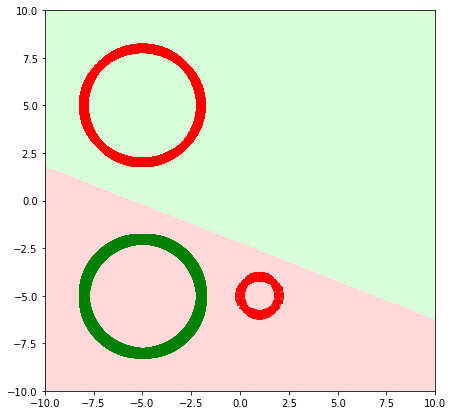

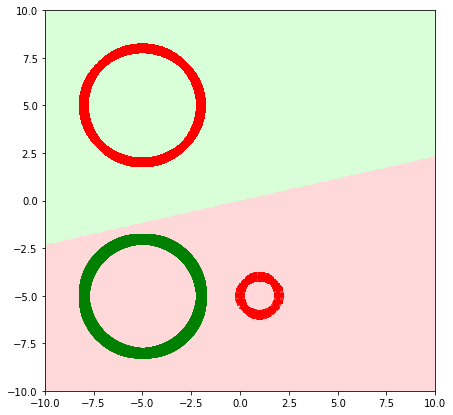

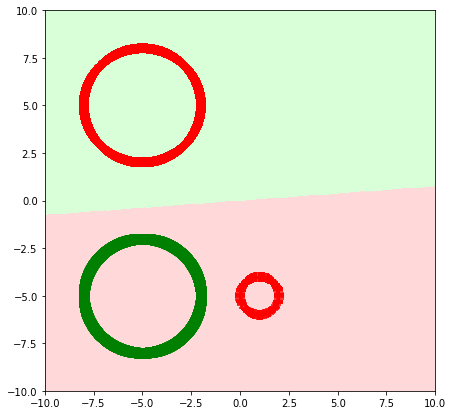

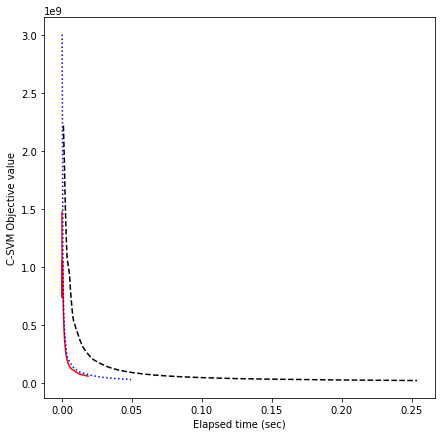

In [3]:
# Get the CSVM gradient
def getCSVMGrad( theta ):
    w = theta[0:-1]
    b = theta[-1]
    discriminant = np.multiply( (X.dot( w ) + b), y )
    g = np.zeros( (y.size,) )
    g[discriminant < 1] = -1
    delb = C * g.dot( y )
    delw = w + C * (X.T * g).dot( y )
    return np.append( delw, delb )

# Get a stochastic gradient for the CSVM objective
# Choose a random data point per iteration
def getCSVMSGrad( theta ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    i = random.randint(0,n-1)
    x = X[i,:]
    discriminant = (x.dot( w ) + b) * y[i]
    g = 0
    if discriminant < 1:
        g = -1
    delb = C * g * y[i]
    delw = w + C * n * (x * g) * y[i]
    return np.append( delw, delb )

# Get a mini-batch stochastic gradient for CSVM
# Choose a random set of B samples per iteration
def getCSVMMBGrad( theta ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    if B <= n:
        samples = random.sample(range(0, n), B)
        X_ = X[samples,:]
        y_ = y[samples]
    else:
        X_ = X
        y_ = y
    discriminant = np.multiply( (X_.dot( w ) + b), y_ )
    g = np.zeros( (B,) )
    g[discriminant < 1] = -1
    delb = C * g.dot( y_ )
    delw = w + C * n/B * (X_.T * g).dot( y_ )
    return np.append( delw, delb )

# Quite standard for strongly convex but non-smooth objectives like CSVM
def getStepLength( grad, t ):
    return eta/(t+1)

# Get the CSVM objective value in order to plot convergence curves
def getCSVMObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    hingeLoss = np.maximum( np.multiply( (X.dot( w ) + b), y ), 0 )
    return 0.5 * w.dot( w ) + C * np.sum(hingeLoss)

# Given a gradient oracle, a step length oracle, an initialization,
# perform GD for a specified number of steps (horizon)
# An "oracle" is a fancy name for a function that does a certain job perfectly
def doGD( gradFunc, stepFunc, init, horizon = 10 ):
    objValSeries = np.zeros( (horizon,) )
    timeSeries = np.zeros( (horizon,) )
    totTime = 0
    theta = init
    cumulative = init
    for t in range( horizon ):
        tic = tm.perf_counter()
        delta = gradFunc( theta )
        theta = theta - stepFunc( delta, t+1 ) * delta
        cumulative = cumulative + theta
        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
        objValSeries[t] = getCSVMObjVal( cumulative/(t+2) )
        timeSeries[t] = totTime
    return (cumulative/(horizon+1), objValSeries, timeSeries)

def mySVM( X ):
    return X.dot(w) + b

# CSVM problems get progressively more and more difficult as C goes up
# All solvers, GD/SGD/sklearn will struggle with large values of C
C = 1
eta = 2
(theta, obj, time) = doGD( getCSVMGrad, getStepLength, np.zeros( (d+1,) ), horizon = 500 )

# Experiment to observe that SGD and MB offer much faster convergence than GD, especially when n is large
# Also, plot just the SGD and MB curves repeatedly to observe that the SGD curve jitters from execution
# to execution (an indication of variance) whereas the MB curve remains relatively stable across executions
C = 1
eta = 2
B = 10
(theta_SGD, obj_SGD, time_SGD) = doGD( getCSVMSGrad, getStepLength, np.zeros( (d+1,) ), horizon = 500 )
(theta_MB, obj_MB, time_MB) = doGD( getCSVMMBGrad, getStepLength, np.zeros( (d+1,) ), horizon = 500 )

w = theta[0:-1]
b = theta[-1]

fig = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
plt.show()

w = theta_SGD[0:-1]
b = theta_SGD[-1]

fig2 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
plt.show()

w = theta_MB[0:-1]
b = theta_MB[-1]

fig3 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
plt.show()

fig4 = pd.getFigure( 7, 7 )
plt.figure( fig4.number )
plt.plot( time, obj, color = 'k', linestyle = '--' )
plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-' )
plt.plot( time_MB, obj_MB, color = 'b', linestyle = ':' )
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
# plt.ylim( 0, 100000 )
plt.show()